In [1]:
%pylab inline
import pandas as pd

import tqdm
import dask
import dask.array as da
from dask.diagnostics import Profiler, ProgressBar

from pyPALM.render import _jit_gen_img_sub as render
old_render = render
from pyPALM.render import _jit_slice_maker, _jit_gauss, _gen_img_sub, _jit_calc_pad

Populating the interactive namespace from numpy and matplotlib


In [2]:
from numba import njit

In [3]:
# make test data
keys_for_render = ["y0", "x0", "sigma_y", "sigma_x"]
test_data = pd.DataFrame(rand(1000, 4) * (800, 800, 2, 2), columns=keys_for_render)
test_data.head()

,y0,x0,sigma_y,sigma_x
0,138.373943,133.457443,0.629548,1.273117
1,627.528717,91.028346,1.859753,1.265156
2,735.875306,0.172791,1.004362,0.596562
3,540.861169,569.595228,1.285595,1.058193
4,512.595072,640.636229,1.929535,0.679453


In [4]:
%timeit img = render((800, 800), test_data[keys_for_render].to_numpy(), 1, np.array([]), True)
img = render((800, 800), test_data[keys_for_render].to_numpy(), 1, np.array([]), True)
%timeit img2 = _gen_img_sub((800, 800), test_data[keys_for_render].to_numpy(), 1, np.array([]), True)
img2 = _gen_img_sub((800, 800), test_data[keys_for_render].to_numpy(), 1, np.array([]), True)

10.5 ms ± 769 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
36 ms ± 3.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
np.array_equal(img, img2)

True

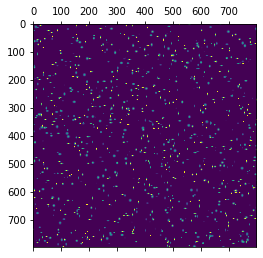

In [6]:
matshow(img, norm=mpl.colors.PowerNorm(0.5), vmax=0.1)

In [7]:
test_datas = [pd.DataFrame(rand(10000, 4) * (800, 800, 2, 2), columns=keys_for_render) for i in range(16)]
test_data_cat = pd.concat(test_datas, ignore_index=True)

In [8]:
%time test_imgs = [render((800, 800), td[keys_for_render].values, 1, np.array([]), True) for td in test_datas]
%time test_img_cat = render((800, 800), test_data_cat[keys_for_render].values, 1, np.array([]), True)

Wall time: 757 ms
Wall time: 664 ms


In [9]:
np.allclose(np.sum(test_imgs, axis=0), test_img_cat)

True

In [10]:
def render2(td):
    return render(np.array((800, 800)), td[keys_for_render].to_numpy(), 5, np.ones(len(td)), True)

delayed_render = dask.delayed(render2)

In [11]:
test_datas = [pd.DataFrame(rand(1000, 4) * (800, 800, 2, 2), columns=keys_for_render) for i in range(48)]
test_data_cat = pd.concat(test_datas, ignore_index=True)

In [12]:
print("Single calculation")
%time render2(test_datas[0])
print()
print("Multi calculation threaded")
%time result_delayed_t = dask.compute(*[delayed_render(td) for td in test_datas], scheduler="threads", num_workers=48)
print()
print("Multi calculation")
%time result = [render2(td) for td in tqdm.tqdm_notebook(test_datas)]
# print()
# print("Multi calculation processes")
# %time result_delayed_p = dask.compute(*[dask.delayed(render2)(td) for td in test_datas], scheduler="processes", num_workers=16)

Single calculation
Wall time: 1.54 s

Multi calculation threaded
Wall time: 3.09 s

Multi calculation



Wall time: 4.95 s


In [13]:
def _gen_img_sub(img, params, mag, multipliers, diffraction_limit):
    # hard coded radius, this is really how many sigmas you want
    # to use to render each gaussian
    radius = 3

    # initialize the image
    s = img.shape
    ymax = s[0]
    xmax = s[1]
    # iterate through all localizations
    for i in range(len(params)):
#         if not np.isfinite(params[i]).all():
#             # skip nans
#             continue
        # pull parameters adjust to new magnification (Numba requires that we expand this out, explicitly)
        y0 = params[i, 0] * mag
        x0 = params[i, 1] * mag
        sy = params[i, 2] * mag
        sx = params[i, 3] * mag
        # adjust parameters if diffraction limit is requested
        if diffraction_limit:
            sy = max(sy, 0.5)
            sx = max(sx, 0.5)
        # calculate the render window size
        wy = int(sy * radius)
        wx = int(sx * radius)
        # calculate the area in the image
        ystart = int(y0) - wy
        yend = ystart + wy * 2
        xstart = int(x0) - wx
        xend = xstart + wx * 2
        # don't go over the edge
        yend = min(yend, ymax)
        ystart = max(ystart, 0)
        xend = min(xend, xmax)
        xstart = max(xstart, 0)
        wy = yend - ystart
        wx = xend - xstart
        if wy == 0 or wx == 0:
            continue
        # adjust coordinates to window coordinates
        y1 = y0 - ystart
        x1 = x0 - xstart
        # generate gaussian
        g = _jit_gauss(wy, wx, y1, x1, sy, sx)
        # weight if requested
        if len(multipliers):
            g *= multipliers[i]
        # update image
        img[ystart:yend, xstart:xend] += g

jit_gen_img_sub = njit(_gen_img_sub, nogil=True)

def render(yx_shape, params, mag, multipliers, diffraction_limit):
    ymax = int(yx_shape[0] * mag)
    xmax = int(yx_shape[1] * mag)
    img = np.zeros((ymax, xmax))
    jit_gen_img_sub(img, params, mag, multipliers, diffraction_limit)
    return img

def render2(td):
    return render(np.array((800, 800)), td[keys_for_render].to_numpy(), 1, np.array([]), True)

delayed_render = dask.delayed(render2)

In [51]:
def _gen_img_sub(yx_shape, params, mag, multipliers, diffraction_limit):
    # hard coded radius, this is really how many sigmas you want
    # to use to render each gaussian
    radius = 5

    # initialize the image
    ymax = int(yx_shape[0] * mag)
    xmax = int(yx_shape[1] * mag)
    img = np.zeros((ymax, xmax))
    # iterate through all localizations
    for i in range(len(params)):
        if not np.isfinite(params[i]).all():
            # skip nans
            continue
        # pull parameters adjust to new magnification (Numba requires that we expand this out, explicitly)
        y0 = params[i, 0] * mag
        x0 = params[i, 1] * mag
        sy = params[i, 2] * mag
        sx = params[i, 3] * mag
        # adjust parameters if diffraction limit is requested
        if diffraction_limit:
            sy = max(sy, 0.5)
            sx = max(sx, 0.5)
        # calculate the render window size
        wy = int(sy * radius * 2.0)
        wx = int(sx * radius * 2.0)
        # calculate the area in the image
        ystart = int(np.rint(y0)) - wy // 2
        yend = ystart + wy
        xstart = int(np.rint(x0)) - wx // 2
        xend = xstart + wx
        # don't go over the edge
        yend = min(yend, ymax)
        ystart = max(ystart, 0)
        xend = min(xend, xmax)
        xstart = max(xstart, 0)
        wy = yend - ystart
        wx = xend - xstart
        if wy == 0 or wx == 0:
            continue
        # adjust coordinates to window coordinates
        y1 = y0 - ystart
        x1 = x0 - xstart
        # generate gaussian
        g = _jit_gauss(wy, wx, y1, x1, sy, sx)
        # weight if requested
        if len(multipliers):
            g *= multipliers[i]
        # update image
        img[ystart:yend, xstart:xend] += g
    return img

render = njit(_gen_img_sub, nogil=True)

def render2(td):
    return render(np.array((800, 800)), td[keys_for_render].to_numpy(), 1, np.array([]), True)

delayed_render = dask.delayed(render2)

In [56]:
test_datas = [pd.DataFrame(rand(500000, 4) * (800, 800, 0.25, 0.25), columns=keys_for_render) for i in range(48)]
test_data_cat = pd.concat(test_datas, ignore_index=True)

In [53]:
print("Single calculation")
%timeit render2(test_datas[0])
print()
print("Multi calculation")
%time result = [render2(td) for td in tqdm.tqdm_notebook(test_datas)]
print()
print("Multi calculation threaded")
with ProgressBar():
    %time result_delayed_t = dask.compute(*[delayed_render(td) for td in test_datas], scheduler="threads", num_workers=48)
# print()
# print("Multi calculation processes")
# %time result_delayed_p = dask.compute(*[dask.delayed(render2)(td) for td in test_datas], scheduler="processes", num_workers=16)

Single calculation
102 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)

Multi calculation


Wall time: 5.08 s

Multi calculation threaded
[########################################] | 100% Completed |  4.1s
Wall time: 4.14 s


In [54]:
def old_render2(td):
    return old_render(np.array((800, 800)), td[keys_for_render].to_numpy(), 1, np.array([]), True)

delayed_old_render = dask.delayed(old_render2)

In [62]:
np.array_equal(old_render2(test_datas[0]), render2(test_datas[0]))

True

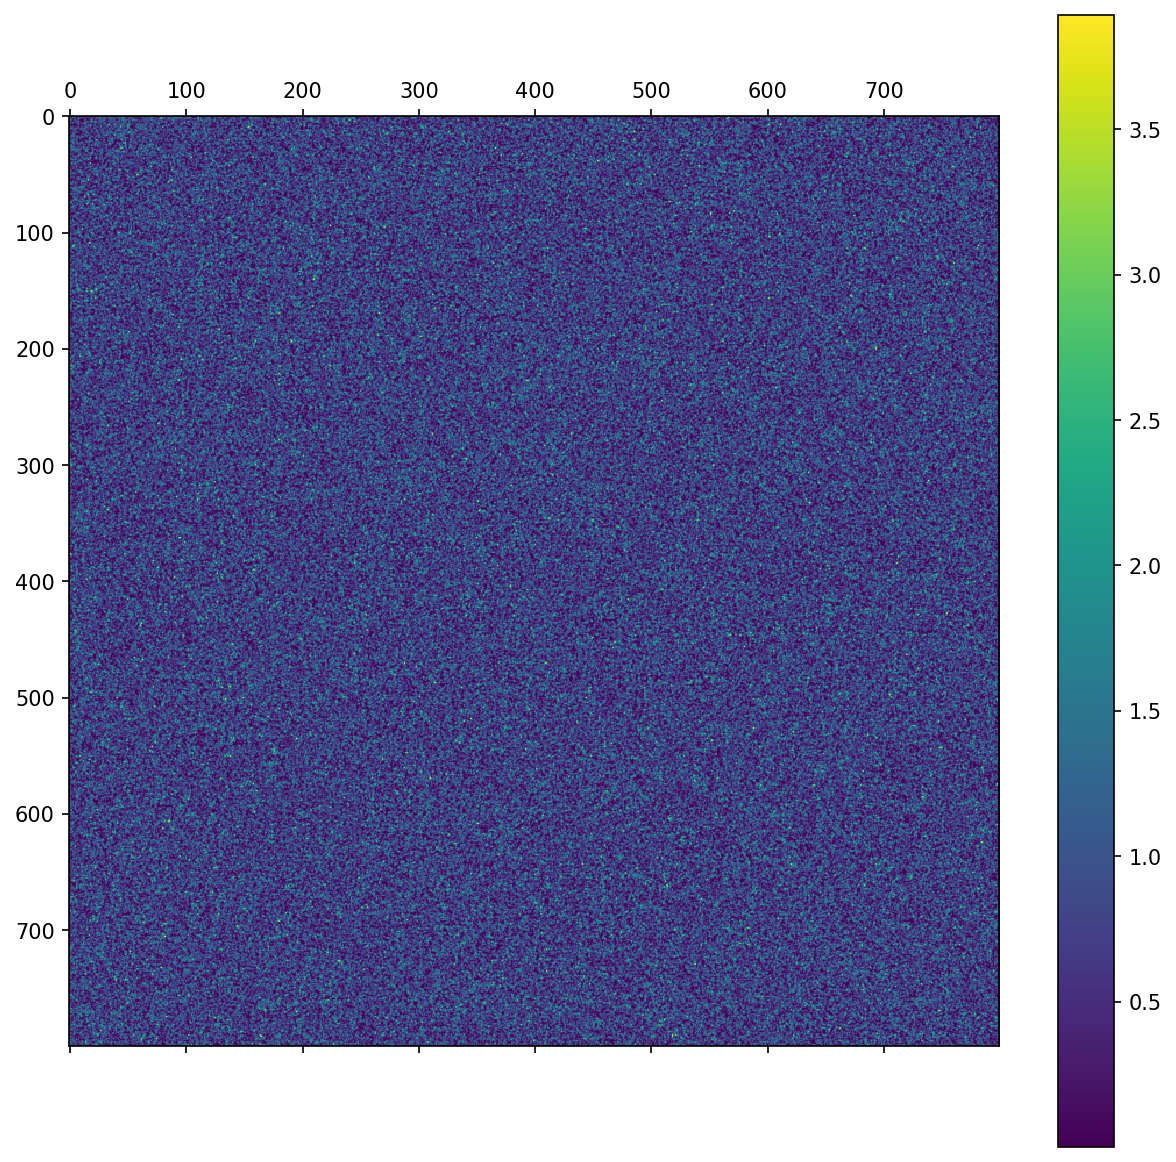

In [63]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
im = ax.matshow(render2(test_datas[0]))
plt.colorbar(im)

In [31]:
print("Single calculation")
%timeit old_render2(test_datas[0])
print()
print("Multi calculation")
%time result = [old_render2(td) for td in tqdm.tqdm_notebook(test_datas)]
print()
print("Multi calculation threaded")
with ProgressBar():
    %time result_delayed_t = dask.compute(*[delayed_old_render(td) for td in test_datas], scheduler="threads", num_workers=48)
# print()
# print("Multi calculation processes")
# %time result_delayed_p = dask.compute(*[dask.delayed(render2)(td) for td in test_datas], scheduler="processes", num_workers=16)

Single calculation
1.66 s ± 30.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Multi calculation


KeyboardInterrupt: 


Multi calculation threaded
[########################################] | 100% Completed |  1min 30.6s
Wall time: 1min 30s


In [422]:
import gc
for i in range(10):
    gc.collect()

# Dask Arrays

## Linear

In [14]:
with ProgressBar():
    with Profiler() as prof_da_linear:
        %time result_da_linear = da.stack([da_render(td) for td in test_datas]).compute()

[########################################] | 100% Completed |  0.6s
Wall time: 718 ms


In [20]:
%time result = np.array([ render((800, 800), td[keys_for_render].values, 1, np.array([]), True) for td in test_datas])
with ProgressBar():
    with Profiler() as prof_delayed:
        %time result_delayed = np.array(dask.compute([delayed_render(td) for td in test_datas]))

Wall time: 990 ms
[########################################] | 100% Completed |  0.6s
Wall time: 750 ms


## Stacked

In [15]:
with ProgressBar():
    with Profiler() as prof_da_stacked:
        %time result_da_stacked = da.stack([da.stack([da_render(td) for td in test_datas[:8]]), da.stack([da_render(td) for td in test_datas[8:]])]).compute()

[########################################] | 100% Completed |  0.7s
Wall time: 775 ms


# Dask delayed to numpy arrays

In [16]:
with ProgressBar():
    with Profiler() as prof_delayed:
        %time result_delayed = np.array(dask.compute([delayed_render(td) for td in test_datas]))

[########################################] | 100% Completed |  0.6s
Wall time: 661 ms


In [17]:
with ProgressBar():
    with Profiler() as prof_delayed_stacked:
        %time result_delayed_stacked = np.array(dask.compute([[delayed_render(td) for td in test_datas[:8]], [delayed_render(td) for td in test_datas[8:]]]))

[########################################] | 100% Completed |  0.6s
Wall time: 672 ms


In [65]:
import time

In [8]:
test_data_cat2 = pd.DataFrame(rand(1000000 * 16, 4) * (800, 800, 2, 2), columns=keys_for_render)

In [9]:
test_data_cat2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000000 entries, 0 to 15999999
Data columns (total 4 columns):
y0         float64
x0         float64
sigma_y    float64
sigma_x    float64
dtypes: float64(4)
memory usage: 488.3 MB


In [14]:
render.signatures

[]

In [5]:
from pyPALM.render import _jit_slice_maker, _jit_gauss, _gen_img_sub

In [37]:
df = dask.delayed(pd.read_csv)("name")
prediction = df['Close'][:-1]
observed = df['Close'][1:]

In [35]:
def func(td, weights, numthreads):
    """This is the gaussian renderer"""
    keys_for_render = ["y0", "x0", "sigma_y", "sigma_x"]
    df_arr = td[keys_for_render].values

    @dask.delayed
    def delayed_render(df_chunk, weight_chunk):
        return render((800, 800), df_chunk, 1, weight_chunk, True)


    chunklen = (len(td) + numthreads - 1) // numthreads
    chunks = [slice(i * chunklen, (i + 1) * chunklen) for i in range(numthreads)]
    # Create argument tuples for each input chunk
    lazy_result = [delayed_render(df_arr[chunk].copy(), weights[chunk].copy()) for chunk in chunks]
    
    print(len(lazy_result))

    return lazy_result

In [36]:
with ProgressBar():
    with Profiler() as prof_delayed_chunked:
        chunked = dask.compute(func(test_data_cat2, rand(len(test_data_cat2)), 32), num_workers=32)

32
[########################################] | 100% Completed |  1min 16.9s


In [34]:
prof_delayed_chunked.visualize()

Figure(id='1505', ...)

In [23]:
with ProgressBar():
    with Profiler() as prof_delayed_chunked:
        chunked = dask.compute(func(test_data_cat2, rand(len(test_data_cat2)), 16), num_workers=32)

16
[########################################] | 100% Completed |  1min 12.4s


In [25]:
with ProgressBar():
    with Profiler() as prof_delayed_chunked:
        chunked = dask.compute(func(test_data_cat2, rand(len(test_data_cat2)), 4))

4
[########################################] | 100% Completed |  1min  3.8s


In [90]:
with ProgressBar():
    with Profiler() as prof_delayed_chunked:
        chunked = dask.compute(func(test_data_cat2, rand(len(test_data_cat2)), 1))

[########################################] | 100% Completed |  2min 14.4s


In [24]:
prof_delayed_chunked.visualize()

Figure(id='1001', ...)